# ALeRCE LSST, TAP queries

```Author: Alejandra Muñoz Arancibia. Last updated: 260224```

This notebook shows how to query the Rubin alert stream data (as well as derived properties) stored by the ALeRCE broker. We show examples of queries to our database via the ALeRCE Table Access Protocol (TAP) service, using the pyvo package to execute Astronomical Data Query Language (ADQL) queries and the pandas package to manipulate output tables as dataframes.

We refer to [this notebook](https://github.com/alercebroker/usecases/tree/master/notebooks/LSST/ALeRCE_LSST_Tables.ipynb) for a detailed description of how Rubin data are stored in the ALeRCE multistream database. In this notebook we also show a brief example of how to query alert image cutouts (hereafter "stamps") using the ALeRCE python client, which is described in more detail in [this notebook](https://github.com/alercebroker/usecases/tree/master/notebooks/LSST/ALeRCE_LSST_Client_Queries.ipynb).

*It is highly recommended that you try this notebook in Google Colab using the following [link](https://colab.research.google.com/github/alercebroker/usecases/blob/master/notebooks/LSST/ALeRCE_LSST_TAP_Queries.ipynb).* This will avoid you from having to sort out library installation problems and focus on the contents of the tutorial. You can try installing the dependencies later in your own system.

### Some settings

In this notebook we use the [ALeRCE python client](https://alerce.readthedocs.io/en/latest/) to retrieve alert image cutouts. Install the ALeRCE python client uncommenting the following line. In case you have a previous alerce package version, note that you need to update it to the latest one to retrieve Rubin data.

In [1]:
#!pip install alerce

Load libraries

In [2]:
#!pip install pyvo

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18
import pyvo as vo
import sys

In [4]:
from alerce.core import Alerce

In [5]:
from IPython.core.display import HTML
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_columns', None)

### Initialize the ALeRCE client

In [6]:
alerce_client = Alerce()

### LSST queries to the ALeRCE multisurvey database

We save Rubin alert stream data in a multisurvey database. We distinguish among data sources by using the field ```tid```, for "telescope identifier". LSST (and more generally, all Rubin data observed with the Simonyi telescope) has ```tid = 1```.

In [7]:
tid = 1

### Rubin identifiers

In LSST alerts, astrophysical objects have different identifiers depending on what they are associated to. Non-moving objects (e.g. supernovae, active galactic nuclei, variable stars) are associated to diaObjects, while known Solar System moving objects (e.g. asteroids) are associated to ssObjects. Identifiers for diaObjects and ssObjects are generated independent of each other by the lsst pipelines. We distinguish among them using the field ```sid```, for "survey identifier".

We use the field ```oid``` as the identifier for each object. This ```oid``` is defined in different ways depending on the availability of diaObject information in the alert, so that

```oid = diaObjectId``` and ```sid = 1``` for objects that have diaObject information, and

```oid = ssObjectId``` and ```sid = 2``` if they only have ssObject information. In case an object has both identifiers (e.g. a known Solar System object was identified at a small angular distance from a non-moving object), we adopt ```oid = diaObjectId``` and ```sid = 1``` while still saving both their diaObject and ssObject data in the respective tables.

We call the identifier for each epoch in every survey as ```measurement_id```. For LSST, this means both field ```diaSourceId``` for detections and field ```diaForcedSourceId``` for forced photometry points are renamed ```measurement_id``` in our database.

## Connect to ALeRCE data via TAP

We connect to the [ALeRCE TAP service](https://tap.alerce.online/) as

In [8]:
alerce_tap = vo.dal.TAPService('https://tap.alerce.online/tap')

## How to query individual objects

Here we illustrate two examples of object queries, useful when the object identifier is known: 1) a diaObject, and 2) a ssObject. A third case, 3) a cone search, will be added in the near future and it is currently covered by a python client query in [this notebook](https://github.com/alercebroker/usecases/tree/master/notebooks/LSST/ALeRCE_LSST_Client_Queries.ipynb). Along these examples we show how to query several properties, like basic statistics, light curves, and stamps.

### Query a diaObject

We choose ```oid = diaObjectId = 313853496686280764```, which can be found in the ALeRCE LSST Explorer as https://lsst.alerce.online/object/313853496686280764?survey=lsst. This object was reported to the [Transient Name Server](https://www.wis-tns.org/) based on ATLAS detections ([Tonry et al. 2025](https://www.wis-tns.org/object/2025agtf/discovery-cert)) and received the name [AT 2025agtf](https://www.wis-tns.org/object/2025agtf). According to NED, its tentative host (WISEA J003724.47-422751.5) has a redshift $z = 0.070493$.

In [9]:
oid = 313853496686280764
sid = 1
z_obj = 0.070493

#### Basic statistics

We query the main properties of this object as

In [10]:
query = '''
SELECT
    *
FROM
    alerce_tap.object
WHERE
    oid = %d
    AND sid = %d
''' % (oid, sid)

df_obj = alerce_tap.search(query).to_table().to_pandas()
display(df_obj)

,oid,tid,sid,meanra,meandec,sigmara,sigmadec,firstmjd,lastmjd,deltamjd,n_det,n_forced,n_non_det,created_date,updated_date
0,313853496686280764,1,1,9.35233,-42.462751,1.279325e-07,1.209520e-07,61024.13142,61069.071516,44.940095,69,0,0,2026-02-13,2026-02-24


#### Light curves

We obtain its light curve (detections and forced photometry points) by querying tables ```detection```, ```lsst_detection```, ```forced_photometry``` and ```lsst_forced_photometry```, and joining them on ```(oid, sid, measurement_id)```

In [11]:
query = '''
SELECT
    alerce_tap.detection.*,
    alerce_tap.lsst_detection.*
FROM
    alerce_tap.detection
JOIN
    alerce_tap.lsst_detection
ON
    alerce_tap.detection.oid = alerce_tap.lsst_detection.oid
    AND alerce_tap.detection.sid = alerce_tap.lsst_detection.sid
    AND alerce_tap.detection.measurement_id = alerce_tap.lsst_detection.measurement_id
WHERE
    alerce_tap.detection.oid = %d
''' % oid
df_dets = alerce_tap.search(query).to_table().to_pandas()

cols = ['oid_', 'sid_', 'measurement_id_', 'created_date_']
df_dets.drop(columns=cols, inplace=True)
display(df_dets)

,oid,sid,measurement_id,mjd,ra,dec,band,created_date,parentdiasourceid,visit,detector,diaobjectid,ssobjectid,raerr,decerr,ra_dec_cov,x,xerr,y,yerr,centroid_flag,apflux,apfluxerr,apflux_flag,apflux_flag_aperturetruncated,isnegative,snr,psfflux,psffluxerr,psflnl,psfchi2,psfndata,psfflux_flag,psfflux_flag_edge,psfflux_flag_nogoodpixels,trailflux,trailfluxerr,trailra,trailraerr,traildec,traildecerr,traillength,traillengtherr,trailangle,trailangleerr,trailchi2,trailndata,trail_flag_edge,dipolemeanflux,dipolemeanfluxerr,dipolefluxdiff,dipolefluxdifferr,dipolelength,dipoleangle,dipolechi2,dipolendata,scienceflux,sciencefluxerr,forced_psfflux_flag,forced_psfflux_flag_edge,forced_psfflux_flag_nogoodpixels,templateflux,templatefluxerr,ixx,iyy,ixy,ixxpsf,iyypsf,ixypsf,shape_flag,shape_flag_no_pixels,shape_flag_not_contained,shape_flag_parent_source,extendedness,reliability,isdipole,dipolefitattempted,timeprocessedmjdtai,timewithdrawnmjdtai,bboxsize,pixelflags,pixelflags_bad,pixelflags_cr,pixelflags_crcenter,pixelflags_edge,pixelflags_nodata,pixelflags_nodatacenter,pixelflags_interpolated,pixelflags_interpolatedcenter,pixelflags_offimage,pixelflags_saturated,pixelflags_saturatedcenter,pixelflags_suspect,pixelflags_suspectcenter,pixelflags_streak,pixelflags_streakcenter,pixelflags_injected,pixelflags_injectedcenter,pixelflags_injected_template,pixelflags_injected_templatecenter,glint_trail,has_stamp
0,313853496686280764,1,313853496686280764,61024.131420,9.352321,-42.462750,3,2026-02-19,0,2025121400756,176,313853496686280764,0,0.000002,1.882404e-06,5.811162e-14,2549.337891,0.035994,3547.108154,0.033921,False,70119.429688,652.025391,False,False,False,159.188461,69393.812500,434.881348,NaN,1670.226440,1681,False,False,False,68759.984375,0.476512,9.352321,NaN,-42.462750,NaN,0.585214,NaN,-84.049362,NaN,NaN,0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,87073.445312,451.603729,False,False,False,14675.601562,9.231125,0.457387,0.431268,0.006412,0.462593,0.435522,-0.000829,False,False,False,False,0.001248,0.999998,False,False,61081.910089,NaN,75,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
1,313853496686280764,1,313853498027933784,61024.138132,9.352326,-42.462753,3,2026-02-19,0,2025121400766,175,313853496686280764,0,0.000001,1.403675e-06,-1.439611e-13,2877.531738,0.021604,3961.210205,0.025570,False,68409.843750,611.623901,False,False,False,185.041367,68777.632812,369.121277,NaN,1684.220825,1681,False,False,False,70109.320312,0.215019,9.352326,NaN,-42.462752,NaN,0.995980,NaN,-165.952118,NaN,NaN,0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,80362.007812,372.005737,False,False,False,10529.717773,20.756777,0.261645,0.308999,-0.038454,0.258571,0.303904,-0.040324,False,False,False,False,0.001486,1.000000,False,False,61081.954267,NaN,35,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
2,313853496686280764,1,313853498568474633,61024.140180,9.352328,-42.462754,3,2026-02-19,0,2025121400770,182,313853496686280764,0,0.000001,1.178417e-06,-1.475000e-13,3910.586182,0.023433,598.746277,0.020682,False,68014.843750,627.713928,False,False,False,184.990326,68613.234375,369.339661,NaN,1655.708984,1681,False,False,False,67103.656250,0.585398,9.352328,NaN,-42.462754,NaN,0.823885,NaN,-92.944420,NaN,NaN,0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,79989.171875,374.356750,False,False,False,10058.903320,28.341106,0.261654,0.230147,-0.025923,0.258306,0.223404,-0.028224,False,False,False,False,0.002646,1.000000,False,False,61081.904548,NaN,36,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
3,313853496686280764,1,313853498703740941,61024.140645,9.352322,-42.462752,3,2026-02-19,0,2025121400771,184,313853496686280764,0,0.000001,1.120077e-06,-2.141331e-13,2997.319336,0.023884,931.918457,0.019451,False,69295.804688,624.457520,False,False,False,188.231567,690

In [12]:
query = '''
SELECT
    alerce_tap.forced_photometry.*,
    alerce_tap.lsst_forced_photometry.*
FROM
    alerce_tap.forced_photometry
JOIN
    alerce_tap.lsst_forced_photometry
ON
    alerce_tap.forced_photometry.oid = alerce_tap.lsst_forced_photometry.oid
    AND alerce_tap.forced_photometry.sid = alerce_tap.lsst_forced_photometry.sid
    AND alerce_tap.forced_photometry.measurement_id = alerce_tap.lsst_forced_photometry.measurement_id
WHERE
    alerce_tap.forced_photometry.oid = %d
''' % oid
df_forced = alerce_tap.search(query).to_table().to_pandas()

cols = ['oid_', 'sid_', 'measurement_id_', 'created_date_']
df_forced.drop(columns=cols, inplace=True)
display(df_forced)

,oid,sid,measurement_id,mjd,ra,dec,band,created_date,visit,detector,psfflux,psffluxerr,scienceflux,sciencefluxerr,timeprocessedmjdtai,timewithdrawnmjdtai


Note that we use integer identifiers for LSST bands. We recover the original band names using the mapping defined in the ```band``` lookup table (LUT)

In [13]:
table_name = 'band'

query = '''
SELECT
    sid, tid, band, band_name, band_order
FROM
    alerce_tap.%s
WHERE
    tid = %d
ORDER BY
    sid ASC, band_order ASC
''' % (table_name, tid)

df_bands = alerce_tap.search(query).to_table().to_pandas()
display(df_bands)

,sid,tid,band,band_name,band_order
0,1,1,6,u,0
1,1,1,1,g,1
2,1,1,2,r,2
3,1,1,3,i,3
4,1,1,4,z,4
5,1,1,5,y,5
6,2,1,6,u,0
7,2,1,1,g,1
8,2,1,2,r,2
9,2,1,3,i,3


We create a function to apply the mapping between columns, useful for also other LUTs in this notebook

In [14]:
def add_mapped_column(df=None, df_lut=None,
                      col=None, col_mapped=None):
    df = df.copy()
    
    cols = ['sid', col]

    if len(df) > 0:
        df[col_mapped] = df.apply(
            lambda row: df_lut.set_index(cols).loc[
            (row['sid'], row[col]), col_mapped] \
            if (row['sid'], row[col]) in df_lut.set_index(cols).index \
            else None,
            axis=1)
    else:
        df[col_mapped] = None

    return df

In [15]:
df_dets = add_mapped_column(
    df=df_dets,
    df_lut=df_bands,
    col='band',
    col_mapped='band_name'
)
df_dets.set_index('oid', inplace=True)

df_forced = add_mapped_column(
    df=df_forced,
    df_lut=df_bands,
    col='band',
    col_mapped='band_name'
)
if len(df_forced) > 0:
    df_forced.set_index('oid', inplace=True)

We display the columns that will be used to build the light curve. In this particular case, the object does not have forced photometry data

In [16]:
cols = ['sid', 'measurement_id', 'band_name', 'mjd',
        'psfFlux', 'psfFluxErr', 'scienceFlux', 'scienceFluxErr']
cols = [x.lower() for x in cols]
display(df_dets[cols])
display(df_forced[cols])

,sid,measurement_id,band_name,mjd,psfflux,psffluxerr,scienceflux,sciencefluxerr
oid,,,,,,,,
313853496686280764,1,313853496686280764,i,61024.131420,69393.812500,434.881348,87073.445312,451.603729
313853496686280764,1,313853498027933784,i,61024.138132,68777.632812,369.121277,80362.007812,372.005737
313853496686280764,1,313853498568474633,i,61024.140180,68613.234375,369.339661,79989.171875,374.356750
313853496686280764,1,313853498703740941,i,61024.140645,69073.429688,366.619385,81144.929688,375.842194
313853496686280764,1,313862198428434499,i,61026.187526,94705.593750,446.347321,107582.703125,456.812897
...,...,...,...,...,...,...,...,...
313853496686280764,1,314011736304779269,z,61060.078867,77321.289062,601.811462,83513.789062,595.499695
313853496686280764,1,314011736438997002,z,61060.079265,71776.125000,610.012024,79541.820312,613.229431
313853496686280764,1,314011736707432455,z,61060.080660,77316.828125,598.632751,84569.539062,598.704407


,sid,measurement_id,band_name,mjd,psfflux,psffluxerr,scienceflux,sciencefluxerr


We show this light curve using a custom function defined in ```lib_multisurvey```

In [17]:
sys.path.append('lib_multisurvey')
import alerce_multisurvey_tools as ms

We define some dictionaries to customize how to show the light curves. We will show both difference and science fluxes, including detections and (when available) forced photometry epochs 

In [18]:
# More parameters (and their default values) defined in
# lib_multisurvey/alerce_multisurvey_tools.py, function plot_lc
lc_params = {
    'from_tap': True,
    'use_mag': False,
    'use_flux': True,
    'show_yr': False,
    'figwidth': 8,
    'pheight': 3,
    'fontsize': 9,
    'alpha': 0.5,
}

In [19]:
epochs = {
    'detections': df_dets,
    'forced_photometry': df_forced,

}
d_objs = ms.group_data_sid_oid(
    sid=sid,
    oid=oid,
    df_dets=epochs['detections'].copy(),
    df_forced=epochs['forced_photometry'].copy() \
        if oid in epochs['forced_photometry'].index else pd.DataFrame(),
        lc_kwargs=ms.init_lc_kwargs()
    )

We show the light curves

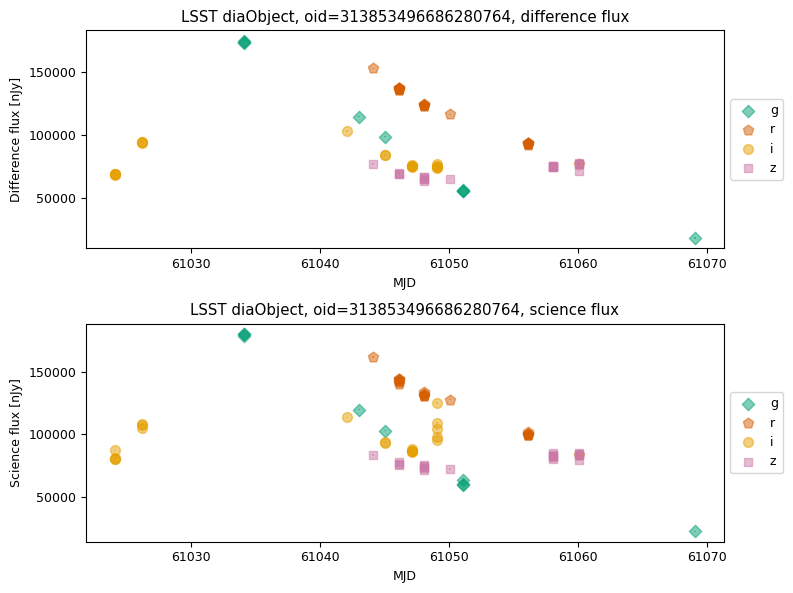

In [20]:
d_objs[sid][oid]['lc_kwargs']['show_forced'] = True

ms.plot_lc(d_objs=d_objs, lc_params=lc_params)

We can show these light curves using magnitude units

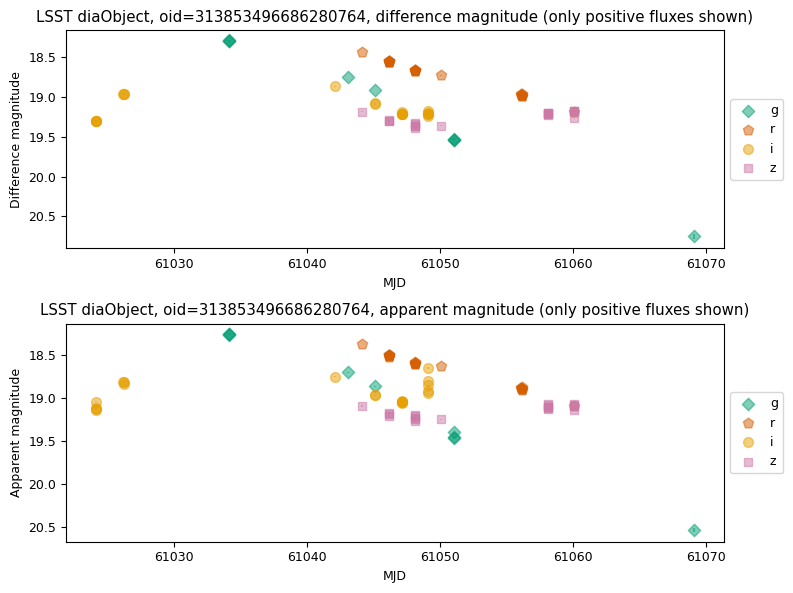

In [21]:
d_objs[sid][oid]['lc_kwargs']['show_flux'] = False
d_objs[sid][oid]['lc_kwargs']['show_forced'] = False

ms.plot_lc(d_objs=d_objs, lc_params=lc_params)

We can also show them using absolute magnitudes, assuming the redshift of the tentative host and the Planck 2018 cosmology

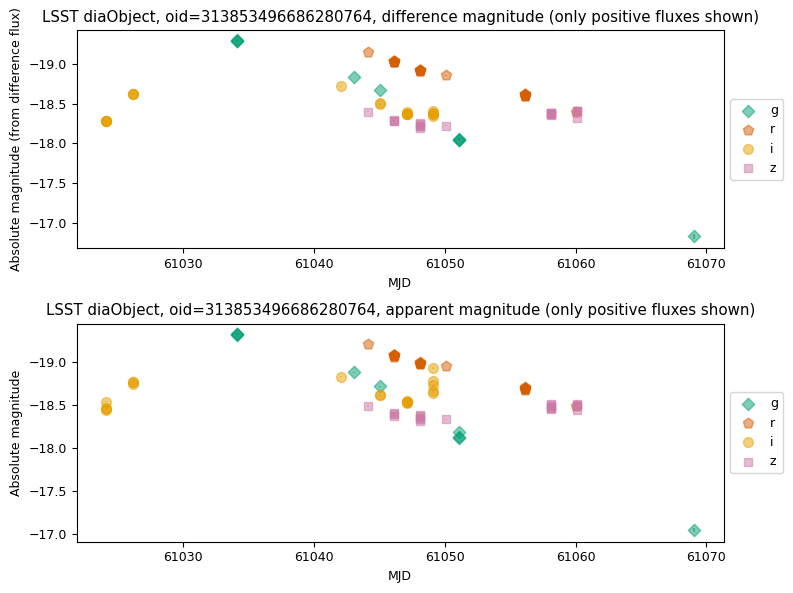

In [22]:
d_objs[sid][oid]['lc_kwargs']['show_absolute_mag'] = True
d_objs[sid][oid]['lc_kwargs']['z_obj'] = z_obj
d_objs[sid][oid]['lc_kwargs']['cosmo'] = Planck18

ms.plot_lc(d_objs=d_objs, lc_params=lc_params)

#### Stamps

We show alert image cutouts for the first 3 detections of this object that triggered alerts. Note that not all stored detections may have triggered an alert, as they may come in an alert as previous detections. The field ```has_stamp``` in our detections dataframe indicates that a given detection triggered an alert, so that we can use it as a mask as

In [23]:
mask = epochs['detections']['has_stamp']
df_dets_this = epochs['detections'][mask].sort_values(by='mjd').iloc[0:3].copy()

cols = ['sid', 'measurement_id', 'band_name', 'mjd',
        'psfFlux', 'psfFluxErr', 'scienceFlux', 'scienceFluxErr',
        'has_stamp']
cols = [x.lower() for x in cols]
display(df_dets_this[cols])

,sid,measurement_id,band_name,mjd,psfflux,psffluxerr,scienceflux,sciencefluxerr,has_stamp
oid,,,,,,,,,
313853496686280764,1,313853496686280764,i,61024.131420,69393.812500,434.881348,87073.445312,451.603729,True
313853496686280764,1,313853498027933784,i,61024.138132,68777.632812,369.121277,80362.007812,372.005737,True
313853496686280764,1,313853498568474633,i,61024.140180,68613.234375,369.339661,79989.171875,374.356750,True


We use the alerce client to retrieve the stamps, obtaining the main fields: Science, Template and Difference

In [24]:
for i, row in df_dets_this.iterrows():
    params = {
        'survey': 'lsst',
        'oid': i,
        'measurement_id': row['measurement_id'],
    }
    df_stamps = alerce_client.plot_stamps(**params)

An extended use of the ALeRCE client to query stamps, including all cutout planes and headers (which include WCS) is presented in [this notebook](https://github.com/alercebroker/usecases/tree/master/notebooks/LSST/ALeRCE_LSST_Client_Queries.ipynb).

#### Latest diaObject information

We query the latest record ingested by our pipeline for this object from the diaObject alert field as

In [25]:
query = '''
SELECT
    *
FROM
    alerce_tap.lsst_dia_object
WHERE
    oid = %d
''' % oid
df_dia = alerce_tap.search(query).to_table().to_pandas()

display(df_dia)

,oid,validitystartmjdtai,ra,raerr,dec,decerr,ra_dec_cov,u_psffluxmean,u_psffluxmeanerr,u_psffluxsigma,u_psffluxndata,u_fpfluxmean,u_fpfluxmeanerr,g_psffluxmean,g_psffluxmeanerr,g_psffluxsigma,g_psffluxndata,g_fpfluxmean,g_fpfluxmeanerr,r_psffluxmean,r_psffluxmeanerr,r_psffluxsigma,r_psffluxndata,r_fpfluxmean,r_fpfluxmeanerr,i_psffluxmean,i_psffluxmeanerr,i_psffluxsigma,i_psffluxndata,i_fpfluxmean,i_fpfluxmeanerr,z_psffluxmean,z_psffluxmeanerr,z_psffluxsigma,z_psffluxndata,z_fpfluxmean,z_fpfluxmeanerr,y_psffluxmean,y_psffluxmeanerr,y_psffluxsigma,y_psffluxndata,y_fpfluxmean,y_fpfluxmeanerr,u_sciencefluxmean,u_sciencefluxmeanerr,g_sciencefluxmean,g_sciencefluxmeanerr,r_sciencefluxmean,r_sciencefluxmeanerr,i_sciencefluxmean,i_sciencefluxmeanerr,z_sciencefluxmean,z_sciencefluxmeanerr,y_sciencefluxmean,y_sciencefluxmeanerr,u_psffluxmin,u_psffluxmax,u_psffluxmaxslope,u_psffluxerrmean,g_psffluxmin,g_psffluxmax,g_psffluxmaxslope,g_psffluxerrmean,r_psffluxmin,r_psffluxmax,r_psffluxmaxslope,r_psffluxerrmean,i_psffluxmin,i_psffluxmax,i_psffluxmaxslope,i_psffluxerrmean,z_psffluxmin,z_psffluxmax,z_psffluxmaxslope,z_psffluxerrmean,y_psffluxmin,y_psffluxmax,y_psffluxmaxslope,y_psffluxerrmean,firstdiasourcemjdtai,lastdiasourcemjdtai,ndiasources,created_date
0,313853496686280764,61084.734613,9.352326,0.000002,-42.462751,0.000002,5.811162e-14,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,110478.46875,88.413109,21691.716797,20,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,117845.867188,89.553978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76731.84375,153166.21875,3707192.5,417.217438,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64,2026-02-19


### Query a ssObject

We choose ```oid = ssObjectId = 20892036583535702```, which has the packed desigation "1992 SV24"

In [26]:
oid = 20892036583535702
sid = 2

We query its main properties and light curve as before

In [27]:
query = '''
SELECT
    *
FROM
    alerce_tap.object
WHERE
    oid = %d
    AND sid = %d
''' % (oid, sid)

df_obj = alerce_tap.search(query).to_table().to_pandas()
display(df_obj)

,oid,tid,sid,meanra,meandec,sigmara,sigmadec,firstmjd,lastmjd,deltamjd,n_det,n_forced,n_non_det,created_date,updated_date
0,20892036583535702,1,2,149.890512,1.767309,3.618641e-08,3.652776e-08,61094.120903,61095.221243,1.10034,178,0,0,2026-02-23,2026-02-24


In [28]:
query = '''
SELECT
    alerce_tap.detection.*,
    alerce_tap.lsst_detection.*
FROM
    alerce_tap.detection
JOIN
    alerce_tap.lsst_detection
ON
    alerce_tap.detection.oid = alerce_tap.lsst_detection.oid
    AND alerce_tap.detection.sid = alerce_tap.lsst_detection.sid
    AND alerce_tap.detection.measurement_id = alerce_tap.lsst_detection.measurement_id
WHERE
    alerce_tap.detection.oid = %d
''' % oid
df_dets = alerce_tap.search(query).to_table().to_pandas()

cols = ['oid_', 'sid_', 'measurement_id_', 'created_date_']
df_dets.drop(columns=cols, inplace=True)
#display(df_dets)

In [29]:
df_dets = add_mapped_column(
    df=df_dets,
    df_lut=df_bands,
    col='band',
    col_mapped='band_name'
)
df_dets.set_index('oid', inplace=True)

In [30]:
display(df_dets)

,sid,measurement_id,mjd,ra,dec,band,created_date,parentdiasourceid,visit,detector,diaobjectid,ssobjectid,raerr,decerr,ra_dec_cov,x,xerr,y,yerr,centroid_flag,apflux,apfluxerr,apflux_flag,apflux_flag_aperturetruncated,isnegative,snr,psfflux,psffluxerr,psflnl,psfchi2,psfndata,psfflux_flag,psfflux_flag_edge,psfflux_flag_nogoodpixels,trailflux,trailfluxerr,trailra,trailraerr,traildec,traildecerr,traillength,traillengtherr,trailangle,trailangleerr,trailchi2,trailndata,trail_flag_edge,dipolemeanflux,dipolemeanfluxerr,dipolefluxdiff,dipolefluxdifferr,dipolelength,dipoleangle,dipolechi2,dipolendata,scienceflux,sciencefluxerr,forced_psfflux_flag,forced_psfflux_flag_edge,forced_psfflux_flag_nogoodpixels,templateflux,templatefluxerr,ixx,iyy,ixy,ixxpsf,iyypsf,ixypsf,shape_flag,shape_flag_no_pixels,shape_flag_not_contained,shape_flag_parent_source,extendedness,reliability,isdipole,dipolefitattempted,timeprocessedmjdtai,timewithdrawnmjdtai,bboxsize,pixelflags,pixelflags_bad,pixelflags_cr,pixelflags_crcenter,pixelflags_edge,pixelflags_nodata,pixelflags_nodatacenter,pixelflags_interpolated,pixelflags_interpolatedcenter,pixelflags_offimage,pixelflags_saturated,pixelflags_saturatedcenter,pixelflags_suspect,pixelflags_suspectcenter,pixelflags_streak,pixelflags_streakcenter,pixelflags_injected,pixelflags_injectedcenter,pixelflags_injected_template,pixelflags_injected_templatecenter,glint_trail,has_stamp,band_name
oid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20892036583535702,2,170046089967697989,61094.120903,150.046613,1.695245,3,2026-02-23,0,2026022200146,127,0,20892036583535702,5.968710e-07,5.686163e-07,2.114894e-14,2433.025635,0.010896,1663.003784,0.010067,False,157267.171875,616.318542,False,False,False,361.475403,156342.203125,431.342316,NaN,1905.405640,1681,False,False,False,158715.000000,0.717786,150.046610,NaN,1.695245,NaN,0.684252,NaN,70.024315,NaN,NaN,0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,157137.171875,423.041809,False,False,False,-88.092972,20.744246,0.268503,0.228522,0.004353,0.258864,0.236431,0.000816,False,False,False,False,0.000076,1.0,False,False,61094.122808,NaN,36,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,i
20892036583535702,2,170046090102440021,61094.121367,150.046515,1.695287,3,2026-02-23,0,2026022200147,128,0,20892036583535702,5.366799e-07,5.677442e-07,-2.791392e-14,1134.366699,0.009392,3153.975830,0.010461,False,156806.515625,622.503479,False,False,False,362.066376,159976.765625,439.122406,NaN,1952.497925,1681,False,False,False,160250.078125,1.807446,150.046513,NaN,1.695282,NaN,0.572765,NaN,77.129128,NaN,NaN,0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,160471.203125,431.783966,False,False,False,-99.677399,21.494648,0.272090,0.248297,0.007587,0.285599,0.254835,0.000715,False,False,False,False,0.009247,1.0,False,False,61094.123125,NaN,40,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,i
20892036583535702,2,170046090236657710,61094.121833,150.046415,1.695338,3,2026-02-23,0,2026022200148,128,0,20892036583535702,5.488657e-07,5.703957e-07,-2.511699e-14,3013.521729,0.009612,1620.410156,0.010509,False,157958.265625,626.728394,False,False,False,359.845764,160339.640625,439.950470,NaN,1920.436279,1681,False,False,False,160485.687500,1.465203,150.046411,NaN,1.695333,NaN,0.553262,NaN,38.645386,NaN,NaN,0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,160881.140625,432.586151,False,False,False,-93.774979,18.757425,0.264259,0.243663,-0.008173,0.280587,0.245444,-0.010476,False,False,False,False,0.007756,1.0,False,False,61094.123596,NaN,38,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,i
20892036583535702,2,170046090374545425,61094.122300,150.046308,1.695379,3,2026-02-23,0,2026022200149,135,0,20892036583535702,5.977757e-07,5.807835e-07,2.818737e-14,

#### Epoch data from the ssSource alert field, and latest mpc_orbits information

We retrieve additional information for this object from the ssSource alert field, which is stored in our ```lsst_ss_detection``` table

In [31]:
query = '''
SELECT
    *
FROM
    alerce_tap.lsst_ss_detection
WHERE
    ssObjectId = %d
''' % oid
df_sso = alerce_tap.search(query).to_table().to_pandas()

display(df_sso)

,measurement_id,ssobjectid,designation,ecllambda,eclbeta,gallon,gallat,elongation,phaseangle,toporange,toporangerate,heliorange,heliorangerate,ephra,ephdec,ephvmag,ephrate,ephratera,ephratedec,ephoffset,ephoffsetra,ephoffsetdec,ephoffsetalongtrack,ephoffsetcrosstrack,helio_x,helio_y,helio_z,helio_vx,helio_vy,helio_vz,helio_vtot,topo_x,topo_y,topo_z,topo_vx,topo_vy,topo_vz,topo_vtot,diadistancerank,created_date
0,170046089967697989,20892036583535702,J92S24V,151.525094,-9.868008,237.323261,41.765140,169.800461,3.305531,1.376814e-08,0.0,2.031122e-08,0.002249,150.046615,1.695242,0.0,0.0,0.0,0.0,0.013991,-0.007864,0.011571,NaN,NaN,-1.787512e-08,9.518858e-09,1.554738e-09,-0.006218,-0.006443,-0.002664,0.011031,-1.192393e-08,6.871356e-09,4.073061e-10,0.001752,0.007959,0.003521,0.011391,1,2026-02-23
1,170046090102440021,20892036583535702,J92S24V,151.524987,-9.868003,237.323138,41.765085,169.800308,3.305576,1.376814e-08,0.0,2.031123e-08,0.002249,150.046515,1.695287,0.0,0.0,0.0,0.0,0.002414,0.000509,0.002360,NaN,NaN,-1.787514e-08,9.518838e-09,1.554730e-09,-0.006218,-0.006443,-0.002664,0.011031,-1.192392e-08,6.871380e-09,4.073170e-10,0.001751,0.007959,0.003521,0.011391,1,2026-02-23
2,170046090236657710,20892036583535702,J92S24V,151.524874,-9.867990,237.323005,41.765034,169.800171,3.305621,1.376815e-08,0.0,2.031123e-08,0.002249,150.046414,1.695331,0.0,0.0,0.0,0.0,0.022888,0.003869,0.022559,NaN,NaN,-1.787516e-08,9.518818e-09,1.554721e-09,-0.006218,-0.006443,-0.002664,0.011031,-1.192392e-08,6.871405e-09,4.073279e-10,0.001751,0.007960,0.003521,0.011392,1,2026-02-23
3,170046090374545425,20892036583535702,J92S24V,151.524758,-9.867989,237.322877,41.764971,169.800034,3.305667,1.376816e-08,0.0,2.031124e-08,0.002249,150.046313,1.695376,0.0,0.0,0.0,0.0,0.019278,-0.016640,0.009735,NaN,NaN,-1.787518e-08,9.518797e-09,1.554713e-09,-0.006218,-0.006443,-0.002664,0.011031,-1.192391e-08,6.871430e-09,4.073389e-10,0.001750,0.007960,0.003521,0.011393,1,2026-02-23
4,170046090510336056,20892036583535702,J92S24V,151.524649,-9.867980,237.322751,41.764919,169.799881,3.305712,1.376817e-08,0.0,2.031125e-08,0.002249,150.046213,1.695421,0.0,0.0,0.0,0.0,0.015369,-0.005427,0.014379,NaN,NaN,-1.787519e-08,9.518778e-09,1.554705e-09,-0.006218,-0.006443,-0.002664,0.011031,-1.192391e-08,6.871455e-09,4.073498e-10,0.001750,0.007961,0.003521,0.011394,1,2026-02-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,170050503271514115,20892036583535702,J92S24V,151.281618,-9.850418,237.043212,41.646231,169.416428,3.426900,1.378770e-08,0.0,2.032687e-08,0.002243,149.827900,1.795545,0.0,0.0,0.0,0.0,0.011394,-0.007854,0.008254,NaN,NaN,-1.791833e-08,9.473920e-09,1.536172e-09,-0.006188,-0.006459,-0.002666,0.011033,-1.191389e-08,6.926284e-09,4.320107e-10,0.001451,0.008113,0.003571,0.011565,1,2026-02-24
174,170050503429849189,20892036583535702,J92S24V,151.281473,-9.850408,237.043046,41.646159,169.416153,3.426988,1.378771e-08,0.0,2.032688e-08,0.002243,149.827767,1.795605,0.0,0.0,0.0,0.0,0.005535,-0.000251,0.005529,NaN,NaN,-1.791835e-08,9.473893e-09,1.536161e-09,-0.006188,-0.006459,-0.002666,0.011033,-1.191388e-08,6.926317e-09,4.320254e-10,0.001450,0.008113,0.003571,0.011565,1,2026-02-24
175,170050503559872585,20892036583535702,J92S24V,151.281360,-9.850400,237.042917,41.646104,169.415939,3.427054,1.378772e-08,0.0,2.032688e-08,0.002243,149.827668,1.795650,0.0,0.0,0.0,0.0,0.012585,-0.003641,0.012047,NaN,NaN,-1.791837e-08,9.473873e-09,1.536153e-09,-0.006188,-0.006459,-0.002666,0.011033,-1.191388e-08,6.926342e-09,4.320365e-10,0.001449,0.008114,0.003571,0.011566,1,2026-02-24
176,170050515778404363,20892036583535702,J92S24V,151.267836,-9.849516,237.027465,41.639397,169.390320,3.435171,1.378885e-08,0.0,2.032773e-08,0.002243,149.815475,1.801128,0.0,0.0,0.0,0.0,0.029983,0.027087,0.012856,NaN,NaN,-1.792072e-08,9.471426e-09,1.535143e-09,-0.006187,-0.006459,-0.002666,0.011033,-1.191334e-08,

And also the latest mpc_orbits alert field information, stored in our ```lsst_mpc_orbits``` table

In [32]:
query = '''
SELECT
    *
FROM
    alerce_tap.lsst_mpc_orbits
WHERE
    ssObjectId = %d
''' % oid
df_mpc = alerce_tap.search(query).to_table().to_pandas()

display(df_mpc)

,ssobjectid,designation,packed_primary_provisional_designation,unpacked_primary_provisional_designation,mpc_orb_jsonb,created_at,updated_at,orbit_type_int,u_param,nopp,arc_length_total,arc_length_sel,nobs_total,nobs_total_sel,a,q,e,i,node,argperi,peri_time,yarkovsky,srp,a1,a2,a3,dt,mean_anomaly,period,mean_motion,a_unc,q_unc,e_unc,i_unc,node_unc,argperi_unc,peri_time_unc,yarkovsky_unc,srp_unc,a1_unc,a2_unc,a3_unc,dt_unc,mean_anomaly_unc,period_unc,mean_motion_unc,epoch_mjd,h,g,not_normalized_rms,normalized_rms,earth_moid,fitting_datetime,created_date,updated_date
0,20892036583535702,1992 SV24,J92S24V,1992 SV24,"{""CAR"": {""covariance"": {""cov00"": 0.000000000000003366688393855647, ""cov01"": 0.000000000000002546015647318532, ""cov02"": -0.0000000000000001871160933993823, ""cov03"": -0.000000000000000007096306654392917, ""cov04"": 0.000000000000000008068032895172029, ""cov05"": -0.000000000000000001335140268148358, ""cov06"": null, ""cov07"": null, ""cov08"": null, ""cov09"": null, ""cov11"": 0.000000000000002792902115592841, ""cov12"": 0.0000000000000001650280681018962, ""cov13"": -0.000000000000000004757067667367092, ""cov14"": 0.000000000000000009247097557706942, ""cov15"": -0.0000000000000000009048389871421244, ""cov16"": null, ""cov17"": null, ""cov18"": null, ""cov19"": null, ""cov22"": 0.000000000000002455706048120685, ""cov23"": -0.0000000000000000002931830515386386, ""cov24"": -0.00000000000000000001563092587752215, ""cov25"": 0.000000000000000001945217311110181, ""cov26"": null, ""cov27"": null, ""cov28"": null, ""cov29"": null, ""cov33"": 0.00000000000000000001676813829702374, ""cov34"": -0.00000000000000000001607123247959571, ""cov35"": 0...",1970-01-01,1970-01-01,-1,0,24,15453.658399,15453.658399,3113,3040,2.753415,2.03523,0.260835,7.09503,222.416104,163.236957,62300.877348,0.0,0.0,0.0,0.0,0.0,0.0,79.3708,1668.806546,0.215723,2.637370e-09,2.621390e-08,9.339780e-09,0.000001,0.000008,0.000008,0.000008,0.0,0.0,0.0,0.0,0.0,0.0,0.000002,0.000002,3.099464e-10,61000.0,14.337,0.15,0.0,0.774505,0.0,1970-01-01,2026-02-24,2026-02-24


We show its coordinates in different systems, colored by MJD. For this we define a function and merge epoch tables

In [33]:
def plot_scatter(df=None, title=None, prop_x=None, prop_y=None,
                 prop_color=None):
    fontsize = 8
    alpha = 0.7
    
    plt.rcParams.update({'font.size': fontsize})
    
    cmap = 'coolwarm'
    fig, ax = plt.subplots(figsize=(5, 2))
    
    sc = ax.scatter(df[prop_x], df[prop_y],
                    c=df[prop_color],
                    cmap=cmap, s=0.5, alpha=alpha)
    plt.colorbar(sc, ax=ax, label=prop_color)
    ax.set_xlabel(prop_x)
    ax.set_ylabel(prop_y)
    
    ax.set_title(title)
    
    plt.tight_layout()
    plt.rcParams.update({'font.size': 12})

In [34]:
cols = ['ssObjectId', 'measurement_id']
cols = [x.lower() for x in cols]

df_dets_sso = pd.merge(df_dets, df_sso,
                       on=cols)
col = 'created_date'
df_dets_sso = df_dets_sso.drop(
    columns=[col + '_x']).rename(columns={col + '_y': col}).copy()

display(df_dets_sso)

,sid,measurement_id,mjd,ra,dec,band,parentdiasourceid,visit,detector,diaobjectid,ssobjectid,raerr,decerr,ra_dec_cov,x,xerr,y,yerr,centroid_flag,apflux,apfluxerr,apflux_flag,apflux_flag_aperturetruncated,isnegative,snr,psfflux,psffluxerr,psflnl,psfchi2,psfndata,psfflux_flag,psfflux_flag_edge,psfflux_flag_nogoodpixels,trailflux,trailfluxerr,trailra,trailraerr,traildec,traildecerr,traillength,traillengtherr,trailangle,trailangleerr,trailchi2,trailndata,trail_flag_edge,dipolemeanflux,dipolemeanfluxerr,dipolefluxdiff,dipolefluxdifferr,dipolelength,dipoleangle,dipolechi2,dipolendata,scienceflux,sciencefluxerr,forced_psfflux_flag,forced_psfflux_flag_edge,forced_psfflux_flag_nogoodpixels,templateflux,templatefluxerr,ixx,iyy,ixy,ixxpsf,iyypsf,ixypsf,shape_flag,shape_flag_no_pixels,shape_flag_not_contained,shape_flag_parent_source,extendedness,reliability,isdipole,dipolefitattempted,timeprocessedmjdtai,timewithdrawnmjdtai,bboxsize,pixelflags,pixelflags_bad,pixelflags_cr,pixelflags_crcenter,pixelflags_edge,pixelflags_nodata,pixelflags_nodatacenter,pixelflags_interpolated,pixelflags_interpolatedcenter,pixelflags_offimage,pixelflags_saturated,pixelflags_saturatedcenter,pixelflags_suspect,pixelflags_suspectcenter,pixelflags_streak,pixelflags_streakcenter,pixelflags_injected,pixelflags_injectedcenter,pixelflags_injected_template,pixelflags_injected_templatecenter,glint_trail,has_stamp,band_name,designation,ecllambda,eclbeta,gallon,gallat,elongation,phaseangle,toporange,toporangerate,heliorange,heliorangerate,ephra,ephdec,ephvmag,ephrate,ephratera,ephratedec,ephoffset,ephoffsetra,ephoffsetdec,ephoffsetalongtrack,ephoffsetcrosstrack,helio_x,helio_y,helio_z,helio_vx,helio_vy,helio_vz,helio_vtot,topo_x,topo_y,topo_z,topo_vx,topo_vy,topo_vz,topo_vtot,diadistancerank,created_date
0,2,170046089967697989,61094.120903,150.046613,1.695245,3,0,2026022200146,127,0,20892036583535702,5.968710e-07,5.686163e-07,2.114894e-14,2433.025635,0.010896,1663.003784,0.010067,False,157267.171875,616.318542,False,False,False,361.475403,156342.203125,431.342316,NaN,1905.405640,1681,False,False,False,158715.000000,0.717786,150.046610,NaN,1.695245,NaN,0.684252,NaN,70.024315,NaN,NaN,0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,157137.171875,423.041809,False,False,False,-88.092972,20.744246,0.268503,0.228522,0.004353,0.258864,0.236431,0.000816,False,False,False,False,0.000076,1.0,False,False,61094.122808,NaN,36,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,i,J92S24V,151.525094,-9.868008,237.323261,41.765140,169.800461,3.305531,1.376814e-08,0.0,2.031122e-08,0.002249,150.046615,1.695242,0.0,0.0,0.0,0.0,0.013991,-0.007864,0.011571,NaN,NaN,-1.787512e-08,9.518858e-09,1.554738e-09,-0.006218,-0.006443,-0.002664,0.011031,-1.192393e-08,6.871356e-09,4.073061e-10,0.001752,0.007959,0.003521,0.011391,1,2026-02-23
1,2,170046090102440021,61094.121367,150.046515,1.695287,3,0,2026022200147,128,0,20892036583535702,5.366799e-07,5.677442e-07,-2.791392e-14,1134.366699,0.009392,3153.975830,0.010461,False,156806.515625,622.503479,False,False,False,362.066376,159976.765625,439.122406,NaN,1952.497925,1681,False,False,False,160250.078125,1.807446,150.046513,NaN,1.695282,NaN,0.572765,NaN,77.129128,NaN,NaN,0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,160471.203125,431.783966,False,False,False,-99.677399,21.494648,0.272090,0.248297,0.007587,0.285599,0.254835,0.000715,False,False,False,False,0.009247,1.0,False,False,61094.123125,NaN,40,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,i,J92S24V,151.524987,-9.868003,237.323138,41.765085,169.800308,3.305576,1.376814e-08,0.0,2.031123e-08,0.002249,150.046515,1.695287,0.0,0.0,0.0,0.0,0.002414,0.000509,0.002360,NaN,NaN,-1.787514e-08,9.518838e-09,1.554730e-09,-0.006218,-0.006443,-0.002664,0.011031,-1.192392e-08,6.871380e-09,4.073170e-10,0.001751,0.007959,0.003521,0.011391,1,2026-02-23
2,2,170046090236657710,610

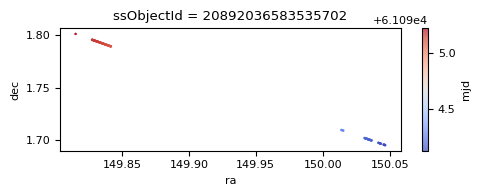

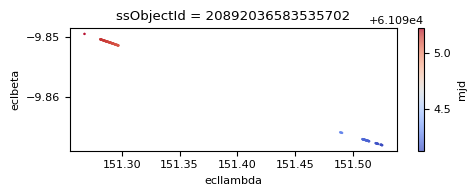

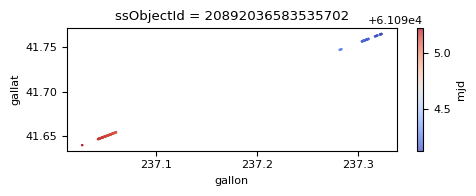

In [35]:
props_x = ['ra', 'eclLambda', 'galLon']
props_x = [x.lower() for x in props_x]

props_y = ['dec', 'eclBeta', 'galLat']
props_y = [x.lower() for x in props_y]

props_color = ['mjd', 'mjd', 'mjd']
title = 'ssObjectId = ' + str(oid)

for (prop_x, prop_y, prop_color) in zip(
    props_x, props_y, props_color):
    plot_scatter(df=df_dets_sso, title=title,
                 prop_x=prop_x, prop_y=prop_y,
                 prop_color=prop_color)